In [1]:
import sys, h5py, pdb,time, glob,os 
from importlib import reload
import pylab as pl, numpy as np
from numpy import log10 as log
from astropy import units as un, constants as cons
import scipy, scipy.stats
from matplotlib import ticker, patches
from mpl_toolkits.mplot3d import Axes3D
sys.path.append('../../pysrc')

In [2]:
import workdirs as wd
import FIRE_files as ff
from FIRE_files import cosmo, u
from projectPlotBasics import *
import first_pass as l
cmap = pl.get_cmap('viridis')
figdir = wd.basedir+'figures/'

Behroozi+18 not loaded
palettable colormaps are not installed
don't have phil's colormaps


In [3]:
CF_path = '../../../cooling_flow/pysrc'
sys.path.append(CF_path)
import cooling_flow as CF, HaloPotential as Halo
%matplotlib inline

In [4]:
simname_turb = 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30'
simname_noturb = 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4'
vc = 200. *un.km/un.s
Rcirc = 10.*un.kpc
Nsnapshots,dt,rmax,subsample = 225,10,40,1
ts = -np.arange(Nsnapshots)*dt
ts = ts-ts[-1]

# load individual track files. skip after creating combined file

In [5]:
#coords,vs,Ts,nHs,tcools = np.zeros((Nsnapshots,0,3)), np.zeros((Nsnapshots,0,3)), np.zeros((Nsnapshots,0)), np.zeros((Nsnapshots,0)), np.zeros((Nsnapshots,0))
#for lastSnapshot in range(226,230):
#    npz_fn = wd.tracksdir+simname+'/particle_tracks_%d_%d_%d_%d_%d_%d_%d.npz'%(Nsnapshots*dt,dt,rmax,vc.value,Rcirc.value,subsample,lastSnapshot)
#    #snapNumbers = range(lastSnapshot-Nsnapshots,lastSnapshot,1)  
#    if os.path.exists(npz_fn):
#        f = np.load(npz_fn)
#    else:
#        print(npz_fn)
#        continue
#    coords = np.concatenate([coords,f['coords']],axis=1)
#    print(lastSnapshot, coords.shape)
#    vs = np.concatenate([vs,f['vs']],axis=1)
#    Ts = np.concatenate([Ts,f['Ts']],axis=1)
#    nHs = np.concatenate([nHs,f['nHs']],axis=1)
#    tcools = np.concatenate([tcools,f['tcools']],axis=1)
#    f.close()

In [6]:
#npz_fn = wd.tracksdir+simname+'/particle_tracks_%d_%d_%d_all.npz'%(Nsnapshots,dt,rmax)
#np.savez(npz_fn,coords=coords[:,::,...],vs=vs[:,::,...],Ts=Ts[:,::,...],nHs=nHs[:,::,...],tcools=tcools[:,::,...])

# load combined track files

In [7]:
class SimObj:
    pass

In [10]:
mu = 0.62
simobjs = [None,None]
for isim,simname in enumerate((simname_noturb,simname_turb)):
    #simdir = wd.simdir+'/%s/output/'%simname
    npz_fn = wd.tracksdir+simname+'/particle_tracks_%d_%d_%d_all.npz'%(Nsnapshots,dt,rmax)
    f = np.load(npz_fn)
    simobjs[isim] = a = SimObj()    
    a.coords,a.vs,a.Ts,a.nHs,a.tcools=f['coords'],f['vs'],f['Ts'],f['nHs'],f['tcools'][:,::,...]
    f.close()
    a.isStar = np.isnan(a.Ts[:,:])
    a.tSF_ind  = np.array([np.concatenate([np.array([True]), a.isStar[:,i]]).nonzero()[0][-1] for i in range(a.isStar.shape[1])])
    a.tSF = ts[a.tSF_ind]
    a.isCool = a.Ts[:,:]<1e5
    a.t105_ind = np.array([np.concatenate([np.array([True]), a.isCool[:,i]]).nonzero()[0][-1] for i in range(a.isCool.shape[1])])
    a.t105= ts[a.t105_ind]    
    a.epsilons = a.Ts / (un.km**2/un.s**2 * cons.m_p / cons.k_B).to('K').value / (2./3* mu) 
    a.cs = (a.epsilons*10/9)**0.5 
    a.nHTs = a.nHs*a.Ts
    a.Ks = (cons.k_B*a.Ts*un.K/(a.nHs*un.cm**-3)**(2/3.)).to('keV*cm**2').value
    a.rhos = a.nHs*cons.m_p.to('g')/ff.X
    a.Edots = a.epsilons * (un.km**2/un.s**2).to('erg*g**-1') * (dt/a.tcools)
    a.dVs = np.log(a.nHs[:-1,:]/a.nHs[1:,:])
    a.dVs = np.pad(a.dVs,((0,1),(0,0)),mode='constant')
    a.PdVs = (mu * ff.X)**-1 * (cons.k_B * un.K / un.g).to('erg*g**-1') * a.nHTs  * a.dVs / a.rhos
    a.xs,a.ys,a.zs = a.coords[:,:,0],a.coords[:,:,1],a.coords[:,:,2]
    a.zs += 0.25 #disk is offset for some reason
    a.rs    = (a.xs**2+a.ys**2+a.zs**2)**0.5
    a.Rs    = (a.xs**2+a.ys**2)**0.5
    a.phis  = np.arctan2(a.ys,a.xs)
    a.thetas = np.arccos(a.zs/a.rs)
    a.dphis = ((a.phis[:-1,:]-a.phis[1:,:])%(2*np.pi))[::-1].cumsum(axis=0)[::-1]
    a.dphis = np.pad(a.dphis,((0,1),(0,0)),mode='constant')
    a.js = np.array([a.coords[:,:,1] * a.vs[:,:,2] - a.coords[:,:,2] * a.vs[:,:,1],
                   a.coords[:,:,2] * a.vs[:,:,0] - a.coords[:,:,0] * a.vs[:,:,2],
                   a.coords[:,:,0] * a.vs[:,:,1] - a.coords[:,:,1] * a.vs[:,:,0]])
    a.js = np.moveaxis(a.js,[0,1],[2,0])
    a.jzs = a.js[:,:,2]
    a.vphis = a.jzs/a.Rs
    a.Omegas = a.jzs/a.Rs**2 * un.km/un.s/un.kpc
    a.vzs = a.vs[:,:,2]
    a.vRs = (a.vs[:,:,0]*a.xs/a.rs + a.vs[:,:,1]*a.ys/a.rs)
    a.vrs = (a.vs[:,:,0]*a.xs/a.rs + a.vs[:,:,1]*a.ys/a.rs + a.vs[:,:,2]*a.zs/a.rs)
    a.v_abs = (a.vRs**2+a.vzs**2+a.vphis**2)**0.5
    # cos𝜃cos𝜙𝐱+cos𝜃sin𝜙𝐲−sin𝜃𝐳)𝜃
    a.vthetas = a.vs[:,:,0]*np.cos(a.thetas)*np.cos(a.phis) + a.vs[:,:,1]*np.cos(a.thetas)*np.sin(a.phis) - a.vs[:,:,2]*np.sin(a.thetas)
    a.vcyls = np.array([a.vRs,a.vphis,a.vzs]); a.vcyls=np.swapaxes(a.vcyls,0,1); a.vcyls=np.swapaxes(a.vcyls,1,2)
    a.vsphs = np.array([a.vrs,a.vphis,a.vthetas]); a.vsphs=np.swapaxes(a.vsphs,0,1); a.vsphs=np.swapaxes(a.vsphs,1,2)
    a.tffs   = (2**0.5*a.rs*un.kpc/vc).to('Myr')
    a.trots  = (a.Omegas**-1).to('Myr')
    a.tflows = (a.rs*un.kpc/(a.vrs*un.km/un.s)).to('Myr')

In [18]:
theta_midbins = np.array([0.1,0.3,0.4,0.5])*np.pi; l = len(theta_midbins)
dtheta = 0.025*np.pi
for a in simobjs:
    a.theta_inds = np.zeros((len(theta_midbins),a.thetas.shape[1]))
    for itheta,theta_midbin in enumerate(theta_midbins):
        theta_infty = np.median(a.thetas[-10:,:],axis=0)
        a.theta_inds[itheta,:] = (theta_infty<theta_midbin+dtheta) & (theta_infty>theta_midbin-dtheta)
    a.theta_inds = a.theta_inds.astype('bool')
    print(a.theta_inds.sum(axis=1))

[2153 5689 6646 6988]
[ 1481  7529 11132 11841]


In [59]:
colors = pl.get_cmap('viridis')(1-np.arange(l)/(l-1))
labels_short = [(r'$%.1f\pi$')%m for im,m in enumerate(theta_midbins/np.pi)]
labels = [(r'$\theta_0=%.1f\pi$')%m for im,m in enumerate(theta_midbins/np.pi)]
def med_and_std(all_vals,xs=ts,theta_inds=None,show_std=True,ls='-'):
    for i,ind in enumerate(theta_midbins):
        vals = all_vals[:,theta_inds[i]]
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        goods = xs<np.median(tSF[theta_inds[i]])
        pl.plot(xs[goods]/1000,ys50[goods],label=labels[i],c=colors[i],ls=ls)
        if show_std: pl.fill_between(xs[goods]/1000,ys16[goods],ys84[goods],facecolor=colors[i],alpha=0.1)    
def med_and_std_dphi(dphis,xs=ts,theta_inds=None):
    for i,ind in enumerate(theta_midbins):
        vals = dphis[:,theta_inds[i]]
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        goods = xs<np.median(tSF[theta_inds[i]])
        for j in np.arange(0,max(ys50[goods]/(2*np.pi))+1):
            goods2 = goods & (ys50//(2*np.pi) == j)
            pl.plot(xs[goods2]/1000,ys50[goods2]/(2*np.pi)%1,label=labels[i],c=colors[i])
            pl.fill_between(xs[goods2]/1000,ys16[goods2]/(2*np.pi)%1,ys84[goods2]/(2*np.pi)%1,facecolor=colors[i],alpha=0.1)            
def relative_dispersion(all_vals,xs=ts,theta_inds=None):
    for i,ind in enumerate(theta_midbins):        
        goods = xs<np.median(tSF[theta_inds[i]])
        vals = all_vals[:,theta_inds[i]][goods,:]
        mean = np.nanmean(vals,axis=1)
        std  = np.nanstd(vals,axis=1)
        pl.plot(xs[goods]/1000,std/mean,label=labels[i],c=colors[i])

In [15]:
def v_turb(vs,xs=ts,theta_inds=None,ls='-'):
    for i,ind in enumerate(theta_midbins):
        vals = vs[:,theta_inds[i],:]
        vs_mean = np.nanmean(vals,axis=1)
        v_turb2  = np.nanmean(((vals[:,:,0].T-vs_mean[:,0])**2  
                              +(vals[:,:,1].T-vs_mean[:,1])**2 
                              +(vals[:,:,2].T-vs_mean[:,2])**2)
                              ,axis=0)
        goods = xs<np.median(tSF[theta_inds[i]])
        pl.plot(xs[goods]/1000,v_turb2[goods],label=labels[i],c=colors[i],ls=ls)     

In [91]:
snapshots_after_105 = 25 // (dt//10)
snapshots_before_105 = 200 // (dt//10)
ts_offset = -np.arange(-snapshots_after_105*dt,(Nsnapshots-snapshots_after_105)*dt,dt)
def shift_arr(arr,t_offset_ind):
    shifted_arr = np.zeros(arr.shape)
    for i in range(arr.shape[1]):
        arr2 = np.array(arr[:,i])
        if t_offset_ind[i]-snapshots_after_105<0:
            arr2[t_offset_ind[i]-snapshots_after_105:]  = np.nan
        if t_offset_ind[i]+snapshots_before_105>Nsnapshots:
            arr2[:t_offset_ind[i]+snapshots_before_105-Nsnapshots]  = np.nan
        shifted_arr[:,i] = np.roll(arr2,-t_offset_ind[i])
    return np.roll(shifted_arr, snapshots_after_105,axis=0)

def med_and_std_shift(all_vals,xs=ts_offset,theta_inds=None,t105_ind=None,show_std=True,ls='-'):
    for i,ind in enumerate(theta_midbins):
        if i==0: continue
        goods = theta_inds[i] & (t105_ind!=0)
        _vals = all_vals[:,goods]
        vals = shift_arr(_vals,t105_ind[goods])
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        ys50 = np.nanmean(vals,axis=1)
        inds = ys16>0
        pl.plot(xs[inds]/1000,ys50[inds],label=labels[i],c=colors[i],ls=ls)
        if show_std: pl.fill_between(xs[inds]/1000,ys16[inds],ys84[inds],facecolor=colors[i],alpha=0.1)    

def relative_dispersion_shift(all_vals,xs=ts_offset,theta_inds=None,t105_ind=None,ls='-'):
    for i,ind in enumerate(theta_midbins):  
        if i==0: continue
        _vals = all_vals[:,theta_inds[i]]
        vals = shift_arr(_vals,t105_ind[theta_inds[i]])
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        inds = ys16>0
        pl.plot(xs[inds]/1000,(ys84-ys16)[inds]/2/ys50[inds],label=labels[i],c=colors[i],ls=ls)

In [92]:
def v_turb_shift(vs,xs=ts_offset,theta_inds=None,t105_ind=None,ls='-'):
    for i,ind in enumerate(theta_midbins):
        _vals = vs[:,theta_inds[i]]
        vals = shift_arr(_vals,t105_ind[theta_inds[i]])
        vs_mean = np.mean(vals,axis=1)
        v_turb = np.mean(((vs[:,:,0].T-vs_mean[:,0])**2 + 
                          (vs[:,:,1].T-vs_mean[:,1])**2 + 
                          (vs[:,:,2].T-vs_mean[:,2])**2)/3,axis=0)**0.5
        pl.plot(xs/1000,v_turb,label=labels[i],c=colors[i],ls=ls)

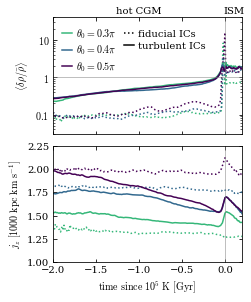

In [93]:
xls = -2.,0.2
pl.figure(figsize=(fig_width_half,4.2)); pl.subplots_adjust(hspace=0.1,wspace=0.1,bottom=0.07)
ax = pl.subplot(211)
prev_labels = labels
for isim,a in enumerate(simobjs):
    ls = (':','-')[isim]
    labels = ('____',prev_labels)[isim]
    #labels = r'non-turbulent ICs',r'turbulent ICs')[isim],'_')[]
    relative_dispersion_shift(a.nHs,theta_inds=a.theta_inds,t105_ind=a.t105_ind,ls=ls)
pl.semilogy()
ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylabel(r'$\langle\delta \rho/\bar \rho\rangle$')
pl.ylim(0.03,40)
pl.axhline(1,c='.5',lw=0.5)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())    
pl.axhline(0.01,c='k',ls=':',label="fiducial ICs")
pl.axhline(0.01,c='k',ls='-',label='turbulent ICs')
pl.legend(ncol=2,frameon=False,labelspacing=0.3,handlelength=1,columnspacing=0.8,handletextpad=0.4)
pl.text(-1,50,'hot CGM',ha='center')
pl.text(0.1,50,'ISM',ha='center')

ax = pl.subplot(212)
for isim,a in enumerate(simobjs):
    ls = (':','-')[isim]
    med_and_std_shift(a.jzs/1000,theta_inds=a.theta_inds,t105_ind=a.t105_ind,ls=ls,show_std=False)    
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.axvline(0,c='.5',lw=0.5)
pl.ylabel(r'$j_z\ [1000\ {\rm kpc}\ {\rm km}\ {\rm s}^{-1}]$')
pl.ylim(1,2.25)
pl.xlim(*xls)
pl.savefig(figdir+'effect_of_turbulence.pdf',bbox_inches='tight')

In [87]:
8600/1.1**3*2**-0.5

4568.834198500606

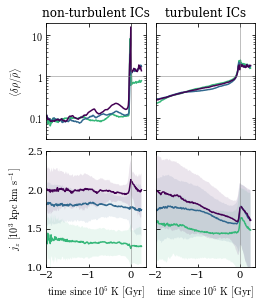

In [40]:
xls = -2.,0.35
pl.figure(figsize=(fig_width_half*1.1,4.5)); pl.subplots_adjust(hspace=0.1,wspace=0.1)
for isim,a in enumerate(simobjs):
    ax = pl.subplot(2,2,isim+1)
    relative_dispersion_shift(a.nHs,theta_inds=a.theta_inds,t105_ind=a.t105_ind)
    pl.semilogy()
    pl.title((r'non-turbulent ICs',r'turbulent ICs')[isim])
    if isim==0: 
        ax.yaxis.set_major_formatter(u.arilogformatter)
        pl.ylabel(r'$\langle\delta \rho/\bar \rho\rangle$')
    else: ax.yaxis.set_major_formatter(ticker.NullFormatter())
    pl.ylim(0.03,20)
    pl.axhline(1,c='.5',lw=0.5)
    pl.xlim(*xls)
    pl.axvline(0,c='.5',lw=0.5)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())    
    ax = pl.subplot(2,2,isim+3)
    med_and_std_shift(a.jzs/1000,theta_inds=a.theta_inds,t105_ind=a.t105_ind)    
    pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
    pl.axvline(0,c='.5',lw=0.5)
    if isim==0:pl.ylabel(r'$j_z\ [10^3\ {\rm kpc}\ {\rm km}\ {\rm s}^{-1}]$')
    else: ax.yaxis.set_major_formatter(ticker.NullFormatter())
    pl.ylim(1,2.5)
    pl.xlim(*xls)
pl.savefig(figdir+'effect_of_turbulence.pdf',bbox_inches='tight')

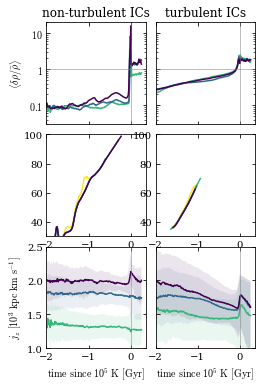

In [43]:
xls = -2.,0.35
pl.figure(figsize=(fig_width_half*1.1,6)); pl.subplots_adjust(hspace=0.1,wspace=0.1)
for isim,a in enumerate(simobjs):
    ax = pl.subplot(3,2,isim+1)
    relative_dispersion_shift(a.nHs,theta_inds=a.theta_inds,t105_ind=a.t105_ind)
    pl.semilogy()
    pl.title((r'non-turbulent ICs',r'turbulent ICs')[isim])
    if isim==0: 
        ax.yaxis.set_major_formatter(u.arilogformatter)
        pl.ylabel(r'$\langle\delta \rho/\bar \rho\rangle$')
    else: ax.yaxis.set_major_formatter(ticker.NullFormatter())
    pl.ylim(0.03,20)
    pl.axhline(1,c='.5',lw=0.5)
    pl.xlim(*xls)
    pl.axvline(0,c='.5',lw=0.5)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())    
    ax = pl.subplot(3,2,isim+3)
    v_turb_shift(a.vs,theta_inds=a.theta_inds,t105_ind=a.t105_ind)
    pl.ylim(30,100)
    pl.xlim(*xls)
    ax = pl.subplot(3,2,isim+5)
    med_and_std_shift(a.jzs/1000,theta_inds=a.theta_inds,t105_ind=a.t105_ind)    
    pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
    pl.axvline(0,c='.5',lw=0.5)
    if isim==0:pl.ylabel(r'$j_z\ [10^3\ {\rm kpc}\ {\rm km}\ {\rm s}^{-1}]$')
    else: ax.yaxis.set_major_formatter(ticker.NullFormatter())
    pl.ylim(1,2.5)
    pl.xlim(*xls)
#pl.savefig(figdir+'effect_of_turbulence.pdf',bbox_inches='tight')

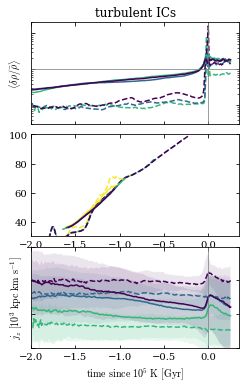

In [45]:
xls = -2.,0.35
pl.figure(figsize=(fig_width_half*1.1,6)); pl.subplots_adjust(hspace=0.1,wspace=0.1)
for isim,a in enumerate(simobjs):
    ls = ('--','-')[isim]
    ax = pl.subplot(311)
    relative_dispersion_shift(a.nHs,theta_inds=a.theta_inds,t105_ind=a.t105_ind,ls=ls)
    pl.semilogy()
    pl.title((r'non-turbulent ICs',r'turbulent ICs')[isim])
    if isim==0: 
        ax.yaxis.set_major_formatter(u.arilogformatter)
        pl.ylabel(r'$\langle\delta \rho/\bar \rho\rangle$')
    else: ax.yaxis.set_major_formatter(ticker.NullFormatter())
    pl.ylim(0.03,20)
    pl.axhline(1,c='.5',lw=0.5)
    pl.xlim(*xls)
    pl.axvline(0,c='.5',lw=0.5)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())    
    ax = pl.subplot(312)
    v_turb_shift(a.vs,theta_inds=a.theta_inds,t105_ind=a.t105_ind,ls=ls)
    pl.ylim(30,100)
    pl.xlim(*xls)
    ax = pl.subplot(313)
    med_and_std_shift(a.jzs/1000,theta_inds=a.theta_inds,t105_ind=a.t105_ind,ls=ls)    
    pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
    pl.axvline(0,c='.5',lw=0.5)
    if isim==0:pl.ylabel(r'$j_z\ [10^3\ {\rm kpc}\ {\rm km}\ {\rm s}^{-1}]$')
    else: ax.yaxis.set_major_formatter(ticker.NullFormatter())
    pl.ylim(1,2.5)
    pl.xlim(*xls)
#pl.savefig(figdir+'effect_of_turbulence.pdf',bbox_inches='tight')

/mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/li

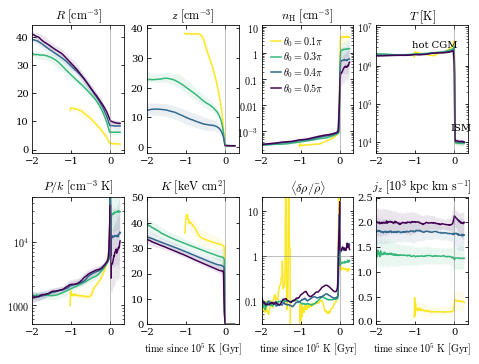

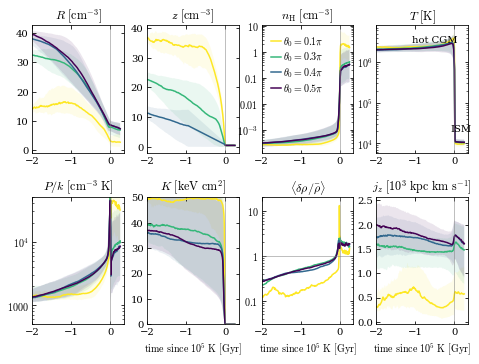

In [25]:
xls = -2.,0.35
for a in simobjs:
    pl.figure(figsize=(fig_width_full*1.1,5.5)); pl.subplots_adjust(hspace=0.35,wspace=0.25)
    ax = pl.subplot(241)
    med_and_std_shift(a.Rs,theta_inds=a.theta_inds,t105_ind=a.t105_ind)
    pl.title(r'$R\ [{\rm cm}^{-3}]$')
    pl.xlim(*xls)
    pl.axvline(0,c='.5',lw=0.5)
    ax = pl.subplot(242)
    med_and_std_shift(a.zs,theta_inds=a.theta_inds,t105_ind=a.t105_ind)
    pl.title(r'$z\ [{\rm cm}^{-3}]$')
    pl.xlim(*xls)
    pl.axvline(0,c='.5',lw=0.5)
    ax = pl.subplot(243)
    med_and_std_shift(a.nHs,theta_inds=a.theta_inds,t105_ind=a.t105_ind)
    pl.title(r'$n_{\rm H}\ [{\rm cm}^{-3}]$')
    pl.legend(loc='upper left',ncol=1,frameon=False,labelspacing=0.2,handlelength=1,columnspacing=0.5,handletextpad=0.2)
    ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
    ax.yaxis.set_major_locator(ticker.LogLocator(numdecs=10,numticks=10))
    pl.xlim(*xls)
    pl.axvline(0,c='.5',lw=0.5)
    ax = pl.subplot(244)
    med_and_std_shift(a.Ts,theta_inds=a.theta_inds,t105_ind=a.t105_ind)
    pl.title(r'$T\ [{\rm K}]$')
    pl.text(-0.5,3e6,r'hot CGM',ha='center')
    pl.text(0.175,2e4,r'ISM',ha='center')
    ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
    pl.xlim(*xls)
    pl.axvline(0,c='.5',lw=0.5)
    ax = pl.subplot(245)
    med_and_std_shift(2.3*a.nHTs,theta_inds=a.theta_inds,t105_ind=a.t105_ind)
    pl.title(r'$P/k\ [{\rm cm}^{-3}\ {\rm K}]$')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    pl.ylim(0.5e3,5e4)
    ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
    pl.xlim(*xls)
    pl.axvline(0,c='.5',lw=0.5)
    ax = pl.subplot(246)
    med_and_std_shift(a.Ks,theta_inds=a.theta_inds,t105_ind=a.t105_ind)
    pl.title(r'$K\ [{\rm keV}\ {\rm cm}^2]$')
    pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
    pl.ylim(0,50)
    pl.xlim(*xls)
    pl.axvline(0,c='.5',lw=0.5)
    ax = pl.subplot(247)
    relative_dispersion_shift(a.nHs,theta_inds=a.theta_inds,t105_ind=a.t105_ind)
    pl.semilogy()
    pl.title(r'$\langle\delta \rho/\bar \rho\rangle$')
    ax.yaxis.set_major_formatter(u.arilogformatter)
    pl.ylim(0.03,20)
    pl.axhline(1,c='.5',lw=0.5)
    pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
    pl.xlim(*xls)
    pl.axvline(0,c='.5',lw=0.5)
    ax = pl.subplot(248)
    med_and_std_shift(a.jzs/1000,theta_inds=a.theta_inds,t105_ind=a.t105_ind)
    pl.title(r'$j_z\ [10^3\ {\rm kpc}\ {\rm km}\ {\rm s}^{-1}]$')
    pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
    pl.axvline(0,c='.5',lw=0.5)
    pl.xlim(*xls)
    pl.savefig(figdir+'tracking_properties_vs_t105_%s.pdf'%simname,bbox_inches='tight')

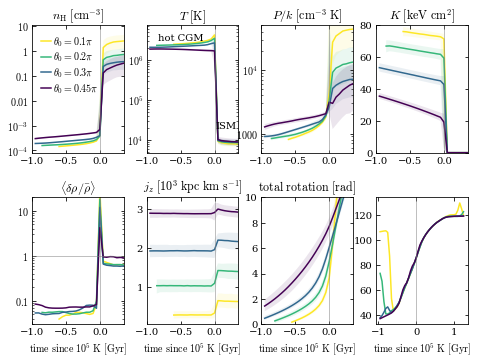

In [78]:
xls = -1.,0.35
pl.figure(figsize=(fig_width_full*1.1,5.5)); pl.subplots_adjust(hspace=0.35,wspace=0.25)
ax = pl.subplot(241)
med_and_std_shift(nHs)
pl.title(r'$n_{\rm H}\ [{\rm cm}^{-3}]$')
pl.legend(loc='upper left',ncol=1,frameon=False,labelspacing=0.2,handlelength=1,columnspacing=0.5,handletextpad=0.2)
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
ax.yaxis.set_major_locator(ticker.LogLocator(numdecs=10,numticks=10))
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(242)
med_and_std_shift(Ts)
pl.title(r'$T\ [{\rm K}]$')
pl.text(-0.5,3e6,r'hot CGM',ha='center')
pl.text(0.175,2e4,r'ISM',ha='center')
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(243)
med_and_std_shift(2.3*nHTs)
pl.title(r'$P/k\ [{\rm cm}^{-3}\ {\rm K}]$')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
pl.ylim(0.5e3,5e4)
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(244)
med_and_std_shift(Ks)
pl.title(r'$K\ [{\rm keV}\ {\rm cm}^2]$')
pl.ylim(0,80)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(245)
relative_dispersion_shift(nHs)
pl.semilogy()
pl.title(r'$\langle\delta \rho/\bar \rho\rangle$')
ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylim(0.03,20)
pl.axhline(1,c='.5',lw=0.5)
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(246)
med_and_std_shift(jzs/1000)
pl.title(r'$j_z\ [10^3\ {\rm kpc}\ {\rm km}\ {\rm s}^{-1}]$')
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.axvline(0,c='.5',lw=0.5)
pl.xlim(*xls)
ax = pl.subplot(247)
med_and_std_shift(dphis)
pl.title(r'${\rm total\ rotation}\ [{\rm rad}]$')
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.axvline(0,c='.5',lw=0.5)
pl.xlim(*xls)
pl.ylim(0,10)
ax = pl.subplot(248)
v_turb_shift(vs)
#pl.title(r'${\rm total\ rotation}\ [{\rm rad}]$')
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.axvline(0,c='.5',lw=0.5)
#pl.xlim(*xls)
#pl.ylim(0,10)
#pl.savefig(figdir+'tracking_properties_vs_t105.pdf',bbox_inches='tight')

Text(0.5, 0, '${\\rm Gyrs}\\ {\\rm since}\\ 10^5\\ {\\rm K}$')

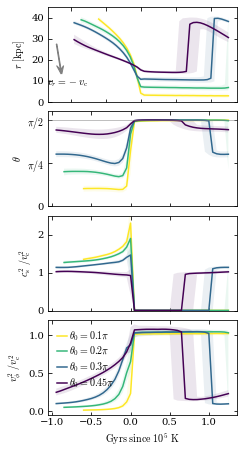

In [61]:
pl.figure(figsize=(fig_width_half,7.5)); pl.subplots_adjust(hspace=0.1)
ax = pl.subplot(411)
med_and_std_shift(rs)
pl.ylabel(r'$r\ [{\rm kpc}]$')
pl.ylim(0,45)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.arrow(-1.2,27.5,0.05,-(0.05*un.Gyr*200*un.km/un.s).to('kpc').value,color='.5',width=0.01,head_width=0.1,head_length=2,overhang=2)
pl.text(-1.05,8,r'$v_r=-v_{\rm c}$',ha='center')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax =pl.subplot(412)
med_and_std_shift(thetas,xs=ts_offset)
pl.ylabel(r'$\theta$')
pl.ylim(0,0.55*np.pi)
pl.axhline(0.5*np.pi,c='.5',lw=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.yaxis.set_major_locator(ticker.FixedLocator([0,np.pi/2,np.pi/4]))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(['0',r'$\pi/2$',r'$\pi/4$']))
ax = pl.subplot(413)
med_and_std_shift((cs/vc.value)**2,xs=ts_offset)
pl.ylabel(r'$c^2_{\rm s}\ / v^2_{\rm c}$')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.ylim(0,2.5)
ax = pl.subplot(414)
med_and_std_shift((vphis/vc.value)**2,xs=ts_offset)
pl.ylabel(r'$v^2_\phi\ / v^2_{\rm c}$')
pl.legend(loc='upper left',ncol=1,frameon=False,labelspacing=0.2,handlelength=1,columnspacing=0.5,handletextpad=0.2)
pl.xlabel(r'${\rm Gyrs}\ {\rm since}\ 10^5\ {\rm K}$')
#pl.savefig(figdir+'tracking_spherical_coordinates_vs_t105.pdf',bbox_inches='tight')

Text(0.5, 0, '${\\rm time}\\ [{\\rm Gyr}]$')

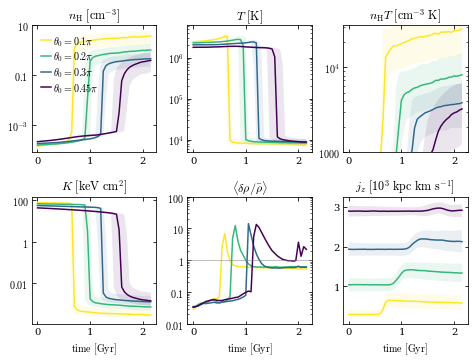

In [62]:
pl.figure(figsize=(fig_width_full*1.1,5.5)); pl.subplots_adjust(hspace=0.35,wspace=0.25)
ax = pl.subplot(231)
med_and_std(nHs)
pl.title(r'$n_{\rm H}\ [{\rm cm}^{-3}]$')
pl.legend(loc='upper left',ncol=1,frameon=False,labelspacing=0.2,handlelength=1,columnspacing=0.5,handletextpad=0.2)
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
ax = pl.subplot(232)
med_and_std(Ts)
pl.title(r'$T\ [{\rm K}]$')
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
ax = pl.subplot(233)
med_and_std(nHTs)
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.title(r'$n_{\rm H} T\ [{\rm cm}^{-3}\ {\rm K}]$')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylim(1e3,10**4.5)
ax = pl.subplot(234)
med_and_std(Ks)
pl.title(r'$K\ [{\rm keV}\ {\rm cm}^2]$')
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$')
ax = pl.subplot(235)
relative_dispersion(nHs)
pl.semilogy()
pl.title(r'$\langle\delta \rho/\bar \rho\rangle$')
ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylim(0.01,100)
pl.axhline(1,c='.5',lw=0.5)
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$')
ax = pl.subplot(236)
med_and_std(jzs/1000)
pl.title(r'$j_z\ [10^3\ {\rm kpc}\ {\rm km}\ {\rm s}^{-1}]$')
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$')

#pl.savefig(figdir+'tracking_properties.pdf',bbox_inches='tight')

In [96]:
def med_and_std_shift_only_data(all_vals,theta_inds=theta_inds):
    res = []
    for i,ind in enumerate(theta_midbins):
        _vals = all_vals[:,theta_inds[i]]
        vals = shift_arr(_vals,t105_ind[theta_inds[i]])
        ysmean = np.nanmean(vals,axis=1)
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        res.append((ys16,ys50,ys84,ysmean))
    return res

a = list(med_and_std_shift_only_data(PdVs))
b = list(med_and_std_shift_only_data(Edots))

In [90]:
print(a[-1][0][::10])
print(b[-1][0][::10])

[-1.05398861e+12 -9.51608607e+11 -9.12654677e+11 -1.78513002e+12
 -1.08907774e+12 -1.29186695e+12 -2.15508716e+12 -2.14004668e+12
 -2.85866238e+12 -2.21683341e+12 -2.15081183e+12 -2.19396097e+12
 -2.05079637e+12 -2.37654332e+12 -2.33253808e+12 -2.64565135e+12
 -3.18605147e+12 -3.48408440e+12 -4.04219204e+12 -3.80814326e+12
 -2.34746175e+12 -1.00000000e+02 -1.00000000e+02]
[ 2.99953013e+13  5.35559435e+13  6.56829500e+13  7.45234430e+12
  5.77270324e+12  4.67028206e+12  3.94469876e+12  3.43046760e+12
  3.02744148e+12  2.71555613e+12  2.45756453e+12  2.23520460e+12
  2.04879345e+12  1.88875960e+12  1.75109659e+12  1.63140775e+12
  1.53005825e+12  1.43912337e+12  1.35655834e+12  1.25299717e+12
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02]


In [ ]:
#P = 2.3 nH k T
#epsilon = erg/g
#epsilons * (cons.m_p / cons.k_B) *2/3mu = Ts .to('K').value 

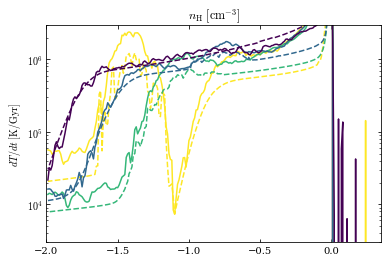

In [105]:
xls = -2.,0.35
ax = pl.subplot(111)
for i,ind in enumerate(theta_midbins):    
    for ii,(ys16,ys50,ys84,ysmean) in enumerate((a[i],b[i])):
#         inds = ys16>0    
        ysmean = ysmean * 2/3*mu * (un.erg/un.g * cons.m_p / cons.k_B /(10*un.Myr)).to('K/Gyr')
        pl.plot(ts_offset/1000,ysmean,label=labels[i],c=colors[i],ls=('-','--')[ii])
#         pl.fill_between(ts_offset[inds]/1000,ys16[inds],ys84[inds],facecolor=colors[i],alpha=0.1)    
pl.title(r'$n_{\rm H}\ [{\rm cm}^{-3}]$')
# pl.legend(loc='upper left',ncol=1,frameon=False,labelspacing=0.2,handlelength=1,columnspacing=0.5,handletextpad=0.2)
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlim(*xls)
pl.ylim(3e3,3e6)
pl.ylabel(r'$dT/dt\ [{\rm K/Gyr}]$')
pl.axvline(0,c='.5',lw=0.5)
# pl.savefig(figdir+'tracking_properties_vs_t105.pdf',bbox_inches='tight')

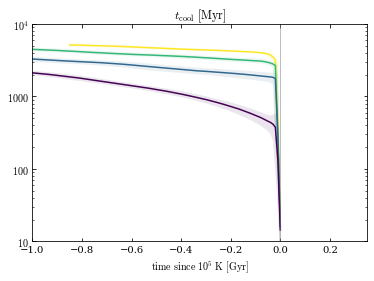

In [490]:
ax=pl.subplot(111)
med_and_std_shift(shift_arr(tcools))
pl.title(r'$t_{\rm cool}\ [{\rm Myr}]$')
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylim(10,10000)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)

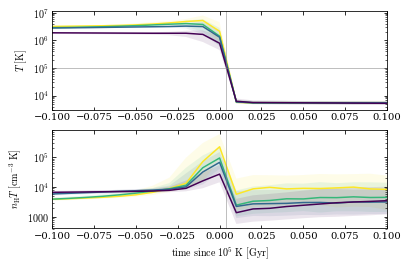

In [497]:
xls = -0.1,0.1
ax=pl.subplot(211)
med_and_std_shift(shift_arr(Ts))
pl.ylabel(r'$T\ [{\rm K}]$')
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlim(*xls)
pl.axvline(0.004,c='.5',lw=0.5)
pl.axhline(1e5,c='.5',lw=0.5)
ax = pl.subplot(212)
med_and_std_shift(shift_arr(nHTs))
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylabel(r'$n_{\rm H} T\ [{\rm cm}^{-3}\ {\rm K}]$')
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.xlim(*xls)
pl.axvline(0.004,c='.5',lw=0.5)

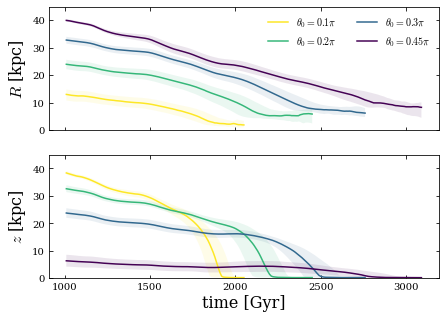

In [180]:
pl.figure(figsize=(7,5))
ax = pl.subplot(211)
med_and_std(Rs)
pl.ylabel(r'$R$ [kpc]',fontsize=16)
pl.legend(loc='upper right',ncol=2,frameon=False,labelspacing=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.ylim(0,45)
pl.subplot(212)
med_and_std(zs)
pl.ylabel(r'$z$ [kpc]',fontsize=16)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.xlabel(r'time [Gyr]',fontsize=16)
pl.ylim(0,45)
pl.savefig('tracking_cylindrical_coordinates.pdf')

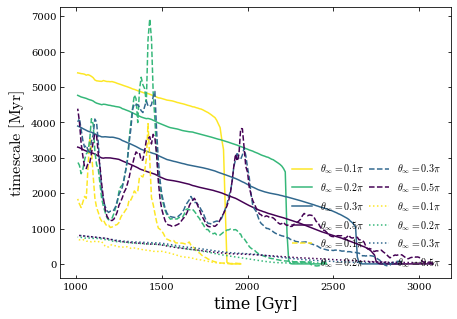

In [50]:
pl.figure(figsize=(7,5))
med_and_std(tcools,ls='-',show_std=False)
med_and_std(-tflows,ls='--',show_std=False)
med_and_std(trots,ls=':',show_std=False)
pl.ylabel(r'${\rm timescale}\ [{\rm Myr}]$',fontsize=16)
pl.legend(loc='lower right',ncol=2,frameon=False,columnspacing=0.5)
pl.xlabel(r'time [Gyr]',fontsize=16)
pl.savefig('tracking_timescale.pdf')

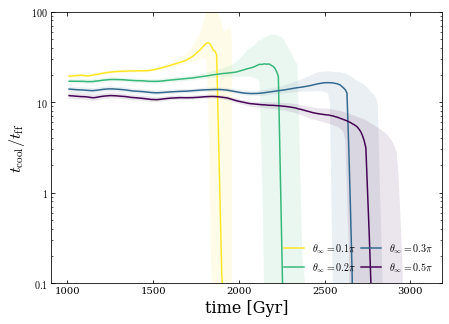

In [52]:
pl.figure(figsize=(7,5))
ax=pl.subplot(111)
med_and_std(tcools/tffs)
pl.ylabel(r'$t_{\rm cool}/t_{\rm ff}$',fontsize=16)
pl.legend(loc='lower right',ncol=2,frameon=False,columnspacing=0.5)
pl.xlabel(r'time [Gyr]',fontsize=16)
pl.semilogy()
pl.ylim(0.1,100)
ax.yaxis.set_major_formatter(u.arilogformatter)
pl.savefig('tracking_tcool_to_tff.pdf')

In [55]:
(2**0.5*10*un.kpc/(200*un.km/un.s)).to('Myr')

<Quantity 69.14035105 Myr>

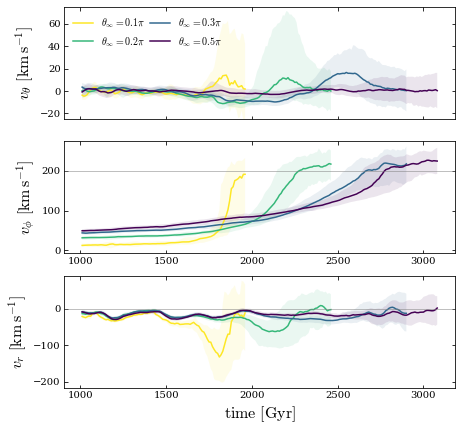

In [134]:
pl.figure(figsize=(7,7))
ax = pl.subplot(311)
med_and_std(vthetas)
pl.ylabel(r'$v_\theta\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.ylim(-25,75)
pl.subplot(312)
med_and_std(vphis)
pl.ylabel(r'$v_\phi\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.axhline(200,c='.5',lw=0.5)
pl.subplot(313)
med_and_std(vrs)
pl.ylabel(r'$v_r\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$',fontsize=16)
pl.axhline(0,c='.5',lw=0.5)
pl.savefig('tracking_velocity.pdf')

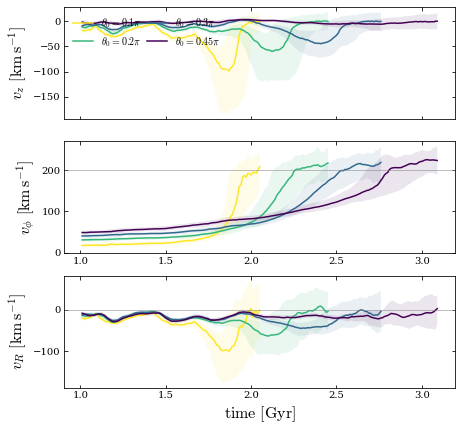

In [436]:
pl.figure(figsize=(7,7))
ax = pl.subplot(311)
med_and_std(vzs)
pl.ylabel(r'$v_z\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
# pl.ylim(-25,75)
pl.subplot(312)
med_and_std(vphis)
pl.ylabel(r'$v_\phi\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.axhline(200,c='.5',lw=0.5)
pl.subplot(313)
med_and_std(vrs)
pl.ylabel(r'$v_R\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$',fontsize=16)
pl.axhline(0,c='.5',lw=0.5)
pl.savefig('tracking_velocity_cylindrical.pdf')

(1000000.0, 5000000.0)

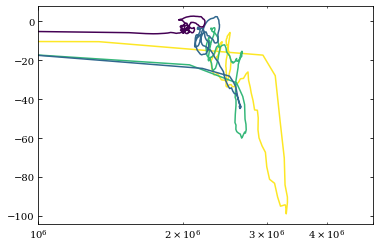

In [446]:
for i,inds in enumerate(theta_inds):
    pl.plot(np.nanmedian(Ts[:,inds],axis=1),
            np.nanmedian(vzs[:,inds],axis=1),
           c=colors[i],label=labels[i])
pl.semilogx()
pl.xlim(1e6,5e6)

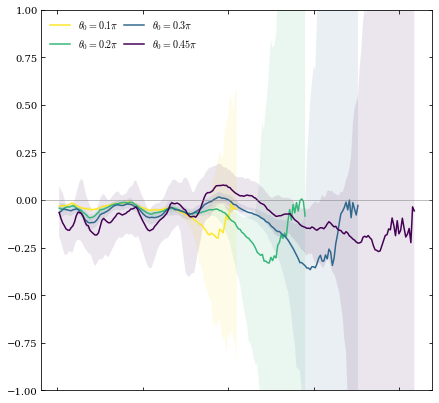

In [439]:
pl.figure(figsize=(7,7))
ax = pl.subplot(111)
# g = vc^2/r * z/R ~ vc^2 z / R^2
# gz = vc^2 z^2 / R^2
# vc_eff = vc*z/R
med_and_std(vzs/(200 * zs/Rs))
# pl.ylabel(r'$v_z\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.ylim(-1,1)
pl.axhline(0,c='.5',lw=0.5)
# pl.savefig('tracking_velocity_cylindrical.pdf')

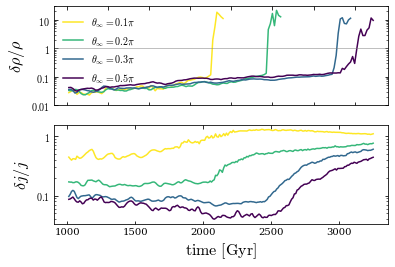

In [66]:
relative_dispersion(jzs)
pl.semilogy()
pl.ylabel(r'$\delta j/j$',fontsize=16)
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$',fontsize=16)
ax.yaxis.set_major_formatter(u.arilogformatter)
pl.savefig('tracking_dispersion.pdf')

/home/ysz5546/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


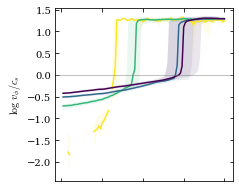

In [227]:
pl.figure(figsize=(7,7))
ax = pl.subplot(221)
med_and_std(log(vphis/cs))
pl.ylabel(r'$\log\ v_\phi/c_s$')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.axhline(0,lw=0.5,c='.5')
# ax = pl.subplot(222)
# med_and_std(log(nHs))
# pl.ylabel(r'$\log\ n_{\rm H}$')
# pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)
# ax.xaxis.set_major_formatter(ticker.NullFormatter())
# pl.subplot(223)
# med_and_std(log(nHTs))
# pl.ylabel(r'$\log\ n_{\rm H} T$')
# pl.xlabel(r'time [Gyr]')
# pl.subplot(224)
# med_and_std(log(Ks))
# pl.ylabel(r'$\log\ K$')
# pl.xlabel(r'time [Gyr]')